### ***Initializing and Importing Packages***

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import seaborn as sns

sns.color_palette("Set2")
sns.set_theme()
# For the image quality of the graphic. 
sns.set(rc={"figure.dpi":200})
# For the size of the graphics
sns.set(rc = {"figure.figsize":(4,2)})
sns.set(font_scale = 0.5)

DataDir = "../../Data/"
FigsDir = "../../Figs/"


### ***Prepairing the Data*** 

In [2]:
symboles = [ 'ADA', 'BTC', 'ETH', 'SOL', 'XRP']
for sym in symboles:
    df_read = pd.read_csv(DataDir + "Stage-4-Data/%s.csv" % sym)
    data = df_read["time_period_start;time_period_end;time_open;time_close;rate_open;rate_high;rate_low;rate_close"].str.split(";", expand=True)
    data.rename(columns={0: 'time_period_start', 1: 'time_period_end', 2: 'time_open', 3: 'time_close',
        4: 'rate_open', 5: 'rate_high', 6: 'rate_low', 7: 'rate_close'}, inplace=True)
    data.to_csv(DataDir + 'Stage-7-Data/%s.csv' % sym , index=False)

#### ***Constructing the Returns' Dataframe*** 

In [94]:
df_t_read = pd.read_csv(DataDir + "Stage-7-Data/%s.csv" % symboles[1])
returns_df = pd.DataFrame()
returns_df['time_close'] = pd.to_datetime(df_t_read['time_close'], dayfirst= True)
for sym in symboles:
    df_read = pd.read_csv(DataDir + "Stage-7-Data/%s.csv" % sym)
    returns_df['%s' % sym] = df_read.rate_close.pct_change(1).mul(100)
    
returns_df = returns_df.iloc[1:]
returns_df.fillna('ffill')
    

,time_close,ADA,BTC,ETH,SOL,XRP
1,2022-01-31 00:09:00+00:00,-0.567315,-0.339329,-0.429146,-0.706729,-0.593215
2,2022-01-31 00:14:00+00:00,-0.051631,-0.079033,-0.222207,-0.117073,-0.048158
3,2022-01-31 00:19:00+00:00,-0.008450,-0.065205,-0.087114,-0.021099,0.043504
4,2022-01-31 00:24:00+00:00,-0.174753,-0.129413,-0.101416,0.016644,-0.078449
5,2022-01-31 00:29:00+00:00,0.076977,-0.024823,-0.012987,0.077142,-0.072341
...,...,...,...,...,...,...
1148,2022-02-03 23:44:00+00:00,0.083392,0.147659,0.200445,0.387029,0.057171
1149,2022-02-03 23:49:00+00:00,0.314611,0.169400,0.279939,0.380504,0.133535
1150,2022-02-03 23:54:00+00:00,-0.330443,-0.203505,-0.239980,-0.386303,-0.092905
1151,2022-02-03 23:59:00+00:00,0.703719,0.629325,0.845698,1.083700,0.540392


In [99]:
plt.style.use('seaborn-pastel')

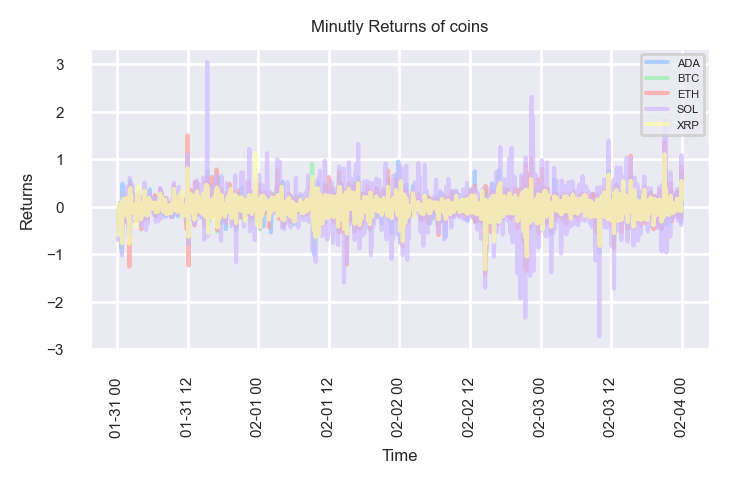

In [100]:
for sym in symboles:
    plt.plot(returns_df['time_close'], returns_df['%s' % sym], label = '%s' % sym, alpha = 0.7)

plt.title('Minutly Returns of coins')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Returns')
plt.legend(loc=1, prop={'size': 4})
plt.show()

### ***The Eddy-Fuller test***

In [114]:
for sym in symboles:
    result = sts.adfuller(returns_df['%s' % sym])
    print('p-value (%s) = %s ' % (sym , result[1]) )


p-value (ADA) = 6.478327163602919e-30 
p-value (BTC) = 2.027917833467083e-30 
p-value (ETH) = 0.0 
p-value (SOL) = 0.0 
p-value (XRP) = 0.0 


### ***Optimum Lag***

In [175]:
var_model = VAR(returns_df.iloc[:, 1:3])
x = var_model.select_order(maxlags=40)
x.summary()

,AIC,BIC,FPE,HQIC
0,-7.559,-7.550*,0.0005216,-7.555*
1,-7.559,-7.532,0.0005214,-7.549
2,-7.559,-7.514,0.0005212,-7.542
3,-7.561,-7.498,0.0005205,-7.537
4,-7.564*,-7.483,0.0005187*,-7.534
5,-7.563,-7.464,0.0005195,-7.525
6,-7.559,-7.441,0.0005216,-7.514
7,-7.561,-7.425,0.0005205,-7.509
8,-7.560,-7.407,0.0005209,-7.502
9,-7.557,-7.386,0.0005223,-7.492


### ***Granger-Cause Test***

In [174]:
maxlag = 4
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
grangers_causation_matrix(returns_df.iloc[:, 1:], variables = returns_df.columns[1:])

,ADA_x,BTC_x,ETH_x,SOL_x,XRP_x
ADA_y,1.0000,0.1140,0.2821,0.0857,0.7744
BTC_y,0.2052,1.0000,0.0681,0.0064,0.0132
ETH_y,0.1977,0.2373,1.0000,0.0655,0.2125
SOL_y,0.0425,0.0070,0.1488,1.0000,0.1050
XRP_y,0.6227,0.0143,0.1338,0.0751,1.0000


In [ ]:
""""
My Conclusion:
After approximately 40 lags:
ETH and SOL Granger-cause ADA.
ADA, SOL and XRP Granger-cause BTC.
ADA and XRP Granger-cause ETH.
ADA, BTC, ETH and XRP Granger-cause SOL.
BTC and SOL Granger-cause XRP.

"""

In [ ]:
#g_result=grangercausalitytests(returns_df[['ADA', 'BTC']], 4)